# Machine Learning Models for  Movie Reviews Sentiment Analysis 

In [1]:
import pandas as pd
import spacy

nlp = spacy.load('en_core_web_lg')

# load the training dataset
df = pd.read_csv('rotten_tomatoes_critic_reviews.csv', delimiter=',', header='infer')
df.columns
data=df[['review_type','review_content']]
data.head()

,review_type,review_content
0,Fresh,A fantasy adventure that fuses Greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,With a top-notch cast and dazzling special eff...
3,Fresh,Whether audiences will get behind The Lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...


In [2]:
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
review_type           0
review_content    65806
dtype: int64


In [3]:
dataCleaned= data.dropna()
dataCleaned.head()
missing_values = dataCleaned.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
review_type       0
review_content    0
dtype: int64


review_type
Fresh     681035
Rotten    383176
Name: count, dtype: int64

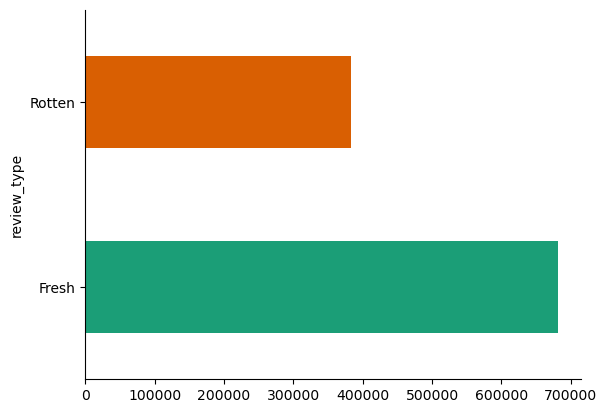

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
dataCleaned.groupby('review_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
dataCleaned['review_type'].value_counts()                                                                                                                                                                                                                                                           

In [5]:
# here we will remove stopwords, punctuations
# as well as we will apply lemmatization

In [6]:
import pandas as pd

target_level_1_data = dataCleaned[dataCleaned['review_type'] == 'Fresh']
target_level_2_data = dataCleaned[dataCleaned['review_type'] == 'Rotten']

sampled_data_level_1 = target_level_1_data.sample(n=10000, random_state=42)
sampled_data_level_2 = target_level_2_data.sample(n=10000, random_state=42)

sampled_data = pd.concat([sampled_data_level_1, sampled_data_level_2])

# Reset index if needed
sampled_data.reset_index(drop=True, inplace=True)
print(sampled_data['review_type'].value_counts())

review_type
Fresh     10000
Rotten    10000
Name: count, dtype: int64


In [7]:
x = sampled_data['review_content']
y = sampled_data['review_type']

### Create a function to clean the data

In [8]:
import string
from spacy.lang.en.stop_words import STOP_WORDS

influential_stop_words = {
    'only', 'alone', 'but', 'except', 'however', 'although', 'though', 'neither', 'nevertheless',
    'either', 'yet', 'not', 'no', 'none', 'nobody', 'nothing', 'nowhere', 'nor', 'without', 'except'
}

punct = string.punctuation
stopwords = list(STOP_WORDS - influential_stop_words)


def text_data_cleaning(sentence):
    doc = nlp(sentence)

    tokens = [] # list of tokens
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens


## Vectorization Feature Engineering (TF-IDF)

In [9]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [10]:
tfidf = TfidfVectorizer(tokenizer=text_data_cleaning)
# tokenizer=text_data_cleaning, tokenization will be done according to this function

## Models training finetuning and evaluation

In [13]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming tfidf is already defined
# tfidf = TfidfVectorizer()

# Define the models
models = {
    'svm': SVC(),
    'naive_bayes': MultinomialNB(),
    'random_forest': RandomForestClassifier(),
    'gradient_boosting': GradientBoostingClassifier()
}

# Define the pipelines
pipelines = {
    'svm': Pipeline([('tfidf', tfidf), ('clf', SVC())]),
    'naive_bayes': Pipeline([('tfidf', tfidf), ('clf', MultinomialNB())]),
    'random_forest': Pipeline([('tfidf', tfidf), ('clf', RandomForestClassifier())]),
    'gradient_boosting': Pipeline([('tfidf', tfidf), ('clf', GradientBoostingClassifier())])
}

# Define the parameter grids
param_grids = {
    'svm': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    'naive_bayes': {
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    'random_forest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    },
    'gradient_boosting': {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.01, 0.1, 1.0]
    }
}

# Split the data with stratify
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Train and evaluate the models
for model_name in models.keys():
    pipeline = pipelines[model_name]
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1)
    grid_search.fit(x_train, y_train)
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    y_train_pred = grid_search.predict(x_train)
    y_test_pred = grid_search.predict(x_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Train accuracy for {model_name}: {train_accuracy:.4f}")
    print(f"Test accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_test_pred)}")
    
    # Save the best model after fine-tuning
    with open(f"{model_name}_tfidf.pickle", 'wb') as f:
        pickle.dump(grid_search.best_estimator_, f)


C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warni

Best parameters for svm: {'clf__C': 10, 'clf__kernel': 'rbf'}
Train accuracy for svm: 0.9998
Test accuracy for svm: 0.7460
Classification report for svm:
              precision    recall  f1-score   support

       Fresh       0.75      0.75      0.75      2000
      Rotten       0.75      0.74      0.75      2000

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warni

Best parameters for naive_bayes: {'clf__alpha': 1.0}
Train accuracy for naive_bayes: 0.8926
Test accuracy for naive_bayes: 0.7425
Classification report for naive_bayes:
              precision    recall  f1-score   support

       Fresh       0.73      0.77      0.75      2000
      Rotten       0.75      0.72      0.74      2000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warni

Best parameters for random_forest: {'clf__max_depth': None, 'clf__n_estimators': 200}
Train accuracy for random_forest: 0.9998
Test accuracy for random_forest: 0.7205
Classification report for random_forest:
              precision    recall  f1-score   support

       Fresh       0.74      0.68      0.71      2000
      Rotten       0.70      0.76      0.73      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\DINA\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warni

Best parameters for gradient_boosting: {'clf__learning_rate': 1.0, 'clf__n_estimators': 200}
Train accuracy for gradient_boosting: 0.8248
Test accuracy for gradient_boosting: 0.6850
Classification report for gradient_boosting:
              precision    recall  f1-score   support

       Fresh       0.70      0.65      0.67      2000
      Rotten       0.67      0.72      0.69      2000

    accuracy                           0.69      4000
   macro avg       0.69      0.69      0.68      4000
weighted avg       0.69      0.69      0.68      4000



In [11]:
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load pre-trained Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Split the data with stratify
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Encode the data
x_train_enc = model.encode(x_train.tolist(), show_progress_bar=False)
x_test_enc = model.encode(x_test.tolist(), show_progress_bar=False)

In [ ]:
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


# Transform embeddings to non-negative values for MultinomialNB
scaler = MinMaxScaler()

x_train_enc_nb = scaler.fit_transform(x_train_enc)
x_test_enc_nb = scaler.transform(x_test_enc)

# Define the models
models = {
    'svm': SVC(probability=True),  # Enable probability estimation
    'naive_bayes': MultinomialNB(),
    'random_forest': RandomForestClassifier(),
    'gradient_boosting': GradientBoostingClassifier()
}

param_grids = {
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'naive_bayes': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'gradient_boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}

# Train and evaluate the models
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1)
    
    if model_name == 'naive_bayes':
        grid_search.fit(x_train_enc_nb, y_train)
    else:
        grid_search.fit(x_train_enc, y_train)
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    if model_name == 'naive_bayes':
        y_train_pred = grid_search.predict(x_train_enc_nb)
        y_test_pred = grid_search.predict(x_test_enc_nb)
    else:
        y_train_pred = grid_search.predict(x_train_enc)
        y_test_pred = grid_search.predict(x_test_enc)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Train accuracy for {model_name}: {train_accuracy:.4f}")
    print(f"Test accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_test_pred)}")
    
    # Save the best model after fine-tuning
    with open(f"{model_name}_sentence_transformers.pickle", 'wb') as f:
        pickle.dump(grid_search.best_estimator_, f)


Best parameters for svm: {'C': 1, 'kernel': 'rbf'}
Train accuracy for svm: 0.8694
Test accuracy for svm: 0.7778
Classification report for svm:
              precision    recall  f1-score   support

       Fresh       0.79      0.76      0.77      2000
      Rotten       0.77      0.80      0.78      2000

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000

Best parameters for naive_bayes: {'alpha': 0.1}
Train accuracy for naive_bayes: 0.7260
Test accuracy for naive_bayes: 0.7462
Classification report for naive_bayes:
              precision    recall  f1-score   support

       Fresh       0.75      0.73      0.74      2000
      Rotten       0.74      0.76      0.75      2000

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000

Best parameters for random_forest: {'ma

In [ ]:
import pickle


# List of reviews to predict
reviews = [
    "The product was excellent and exceeded my expectations.",
    "Worst experience ever. Will not buy again.",
    "It was okay, not great but not bad either.",
    "I love it! Will definitely recommend to others."
]

# Loop through each model and its vectorizer, load them, and make predictions
for model_filename, vectorizer_filename in zip(model_filenames, vectorizer_filenames):
    with open(model_filename, 'rb') as model_file, open(vectorizer_filename, 'rb') as vectorizer_file:
        model = pickle.load(model_file)
        vectorizer = pickle.load(vectorizer_file)
    
    # Encode the reviews using the vectorizer
    X_reviews = vectorizer.transform(reviews)
    
    # Predict the class of the reviews
    predictions = model.predict(X_reviews)
    
    # Print the predictions
    print(f'Predictions using {model_filename}:')
    for review, prediction in zip(reviews, predictions):
        print(f"Review: {review}\nPrediction: {prediction}\n")
    print('\n' + '='*50 + '\n')


In [14]:
import pickle
from sentence_transformers import SentenceTransformer

# List of model filenames
model_filenames = ['svm_sentence_transformers.pickle', 'random_forest_sentence_transformers.pickle', 'naive_bayes_sentence_transformers.pickle']  # Add more model filenames as needed
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# List of reviews to predict
reviews = [
    'An absolute masterpiece! The Shawshank Redemption is a tale of hope, friendship, and resilience. Tim Robbins and Morgan Freeman deliver stellar performances, and the story is deeply moving. The film’s message about the power of hope is timeless and profound. A must-watch!',
    'Despite the hype, Batman v Superman was a disappointment. The plot was convoluted, and the pacing was all over the place. While Ben Affleck and Henry Cavill gave decent performances, the film felt like it was trying to do too much at once without succeeding in any of its goals. The overuse of CGI didn’t help either.',
    "Cats was an unfortunate misstep. The visual effects were unsettling, and the plot was nearly nonexistent. Even with a star-studded cast, the film couldn’t overcome its many flaws. It felt more like a surreal fever dream than a cohesive story. It’s hard to recommend this to anyone, even die-hard fans of the original musical.",
    "nception is a mind-bending journey through the world of dreams. Christopher Nolan’s direction is brilliant, and the visual effects are stunning. Leonardo DiCaprio leads a fantastic cast, and the plot keeps you on the edge of your seat. It’s an intellectual and thrilling experience that stays with you long after it ends."
]

# Load the Sentence Transformer model

# Encode the reviews using the Sentence Transformer
X_reviews = model.encode(reviews)

# Loop through each model, load it, and make predictions
for model_filename in model_filenames:
    with open(model_filename, 'rb') as model_file:
        model = pickle.load(model_file)
    
    # Predict the class of the reviews
    predictions = model.predict(X_reviews)
    
    # Print the predictions
    print(f'Predictions using {model_filename}:')
    for review, prediction in zip(reviews, predictions):
        print(f"Review: {review}\nPrediction: {prediction}\n")
    print('\n' + '='*50 + '\n')


Predictions using svm_sentence_transformers.pickle:
Review: An absolute masterpiece! The Shawshank Redemption is a tale of hope, friendship, and resilience. Tim Robbins and Morgan Freeman deliver stellar performances, and the story is deeply moving. The film’s message about the power of hope is timeless and profound. A must-watch!
Prediction: Fresh

Review: Despite the hype, Batman v Superman was a disappointment. The plot was convoluted, and the pacing was all over the place. While Ben Affleck and Henry Cavill gave decent performances, the film felt like it was trying to do too much at once without succeeding in any of its goals. The overuse of CGI didn’t help either.
Prediction: Rotten

Review: Cats was an unfortunate misstep. The visual effects were unsettling, and the plot was nearly nonexistent. Even with a star-studded cast, the film couldn’t overcome its many flaws. It felt more like a surreal fever dream than a cohesive story. It’s hard to recommend this to anyone, even die-har